# CNN model using Pytorch

## Import libraries

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


## Load the Data

In [ ]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_letters/lett

## View Data

In [ ]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

In [ ]:
characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

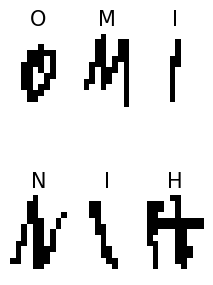

In [ ]:
plt.figure(figsize=(2.5, 3.5))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+train.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Preprocessing Images for Training

In [ ]:
path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

Add weights:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = train['nombre'].unique()
class_weights = compute_class_weight('balanced', classes=class_labels, y=train['nombre'])

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Create Data loader:

In [ ]:
train_loader = DataLoader(train_generator, batch_size=16, shuffle=True)
valid_loader = DataLoader(validation_generator, batch_size=16, shuffle=False)

Verify de data loaders work correctly:

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape)  # This will give you the shape of the batch of images
    print(labels.shape)  # And this will give you the shape of the batch of labels
    break  # Just to demonstrate, stop after the first batch

Batch 0:
torch.Size([16, 1, 10, 14])
torch.Size([16, 1])


## Training function

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        self.best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(self.best_model_wts, 'checkpoint.pt')

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}  # Store average losses per epoch

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    early_stopping = EarlyStopping(patience=5, delta=0)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                labels = labels.squeeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save the average loss for the epoch
            losses[phase].append(epoch_loss)

            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping(epoch_loss, model)

            acc_history[phase].append(epoch_acc)

        print()

        if early_stopping.early_stop:
            print("Early stopping")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    if early_stopping.best_model_wts is not None:
        model.load_state_dict(early_stopping.best_model_wts)
    else:
        model.load_state_dict(best_model_wts)
    return model, acc_history, losses

## Initialize model

In [ ]:
def initialize_model(num_classes):
    # Resnet18
    model = models.resnet18()

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=num_classes, bias=True))

    input_size = 224

    return model, input_size

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# Number of classes in the dataset
num_classes = len(alphabets)
print('num classes:', num_classes)

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

num classes: 29
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

## Run Training and Validation

In [30]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Number of epochs to train fors
num_epochs = 20

optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)

dataloaders_dict = {"train": train_loader, "valid": valid_loader}

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.7168 Acc: 0.6647
valid Loss: 0.3765 Acc: 0.8118

Epoch 1/19
----------
train Loss: 0.4238 Acc: 0.7808
valid Loss: 0.3730 Acc: 0.8412

Epoch 2/19
----------
train Loss: 0.3592 Acc: 0.8202
valid Loss: 0.3285 Acc: 0.8375

Epoch 3/19
----------
train Loss: 0.3210 Acc: 0.8383
valid Loss: 0.2984 Acc: 0.8868

Epoch 4/19
----------
train Loss: 0.2986 Acc: 0.8515
valid Loss: 0.3159 Acc: 0.8727

Epoch 5/19
----------
train Loss: 0.2892 Acc: 0.8569
valid Loss: 0.3188 Acc: 0.8839

Epoch 6/19
----------
train Loss: 0.2828 Acc: 0.8644
valid Loss: 0.3097 Acc: 0.8723

Epoch 7/19
----------
train Loss: 0.2715 Acc: 0.8677
valid Loss: 0.2787 Acc: 0.8803

Epoch 8/19
----------
train Loss: 0.2593 Acc: 0.8743
valid Loss: 0.2964 Acc: 0.8736

Epoch 9/19
----------
train Loss: 0.2537 Acc: 0.8760
valid Loss: 0.3197 Acc: 0.8925

Epoch 10/19
----------
train Loss: 0.2489 Acc: 0.8778
valid Loss: 0.3204 Acc: 0.8969

Epoch 11/19
----------
train Loss: 0.2413 Acc: 0.8791
valid Loss

In [31]:
torch.save(model.state_dict(), 'cnn_model_v9.pth')

In [32]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

In [33]:
# Ensure that your model is on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Example usage with the model predictions
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in validation_generator:
        # Ensure the images tensor has the shape (batch_size, channels, height, width)
        if images.dim() == 3:
            images = images.unsqueeze(0)

        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)  # Move labels to the same device as the model (if necessary)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')


Nombre de lletres correctes: 17644
Percentatge de lletres correctes: 90.1768373709496%


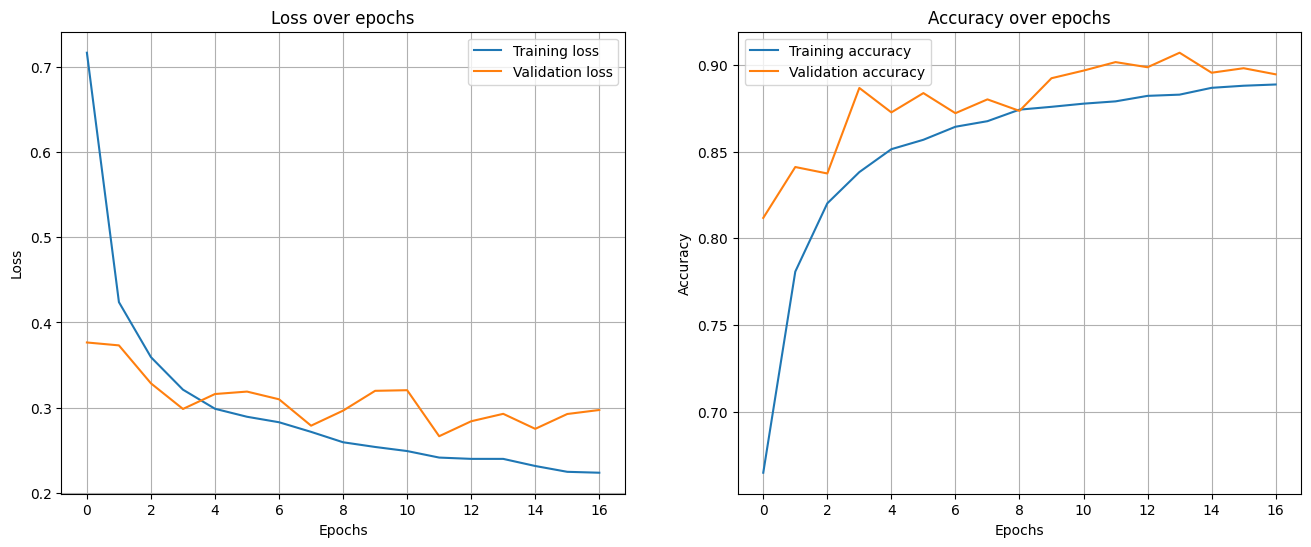

In [34]:
train_losses = losses["train"]
val_losses = losses["valid"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation losses
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

train_accuracies = [acc.cpu().detach().numpy() for acc in hist['train']]
val_accuracies = [acc.cpu().detach().numpy() for acc in hist['valid']]

# Plot the training and validation accuracies
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()
